In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gamma
import sys
sys.path.append('../../style')
from style_config import StyleConfig

# Apply consistent styling
StyleConfig.apply_style()

Running grid search: 11 xG values × 11 xGA values
Total combinations: 121
Matches per combination: 10000
This may take a few minutes...

Completed 1/121 combinations
Completed 20/121 combinations
Completed 40/121 combinations
Completed 60/121 combinations
Completed 80/121 combinations
Completed 100/121 combinations
Completed 120/121 combinations

Grid search complete! Generating visualizations...



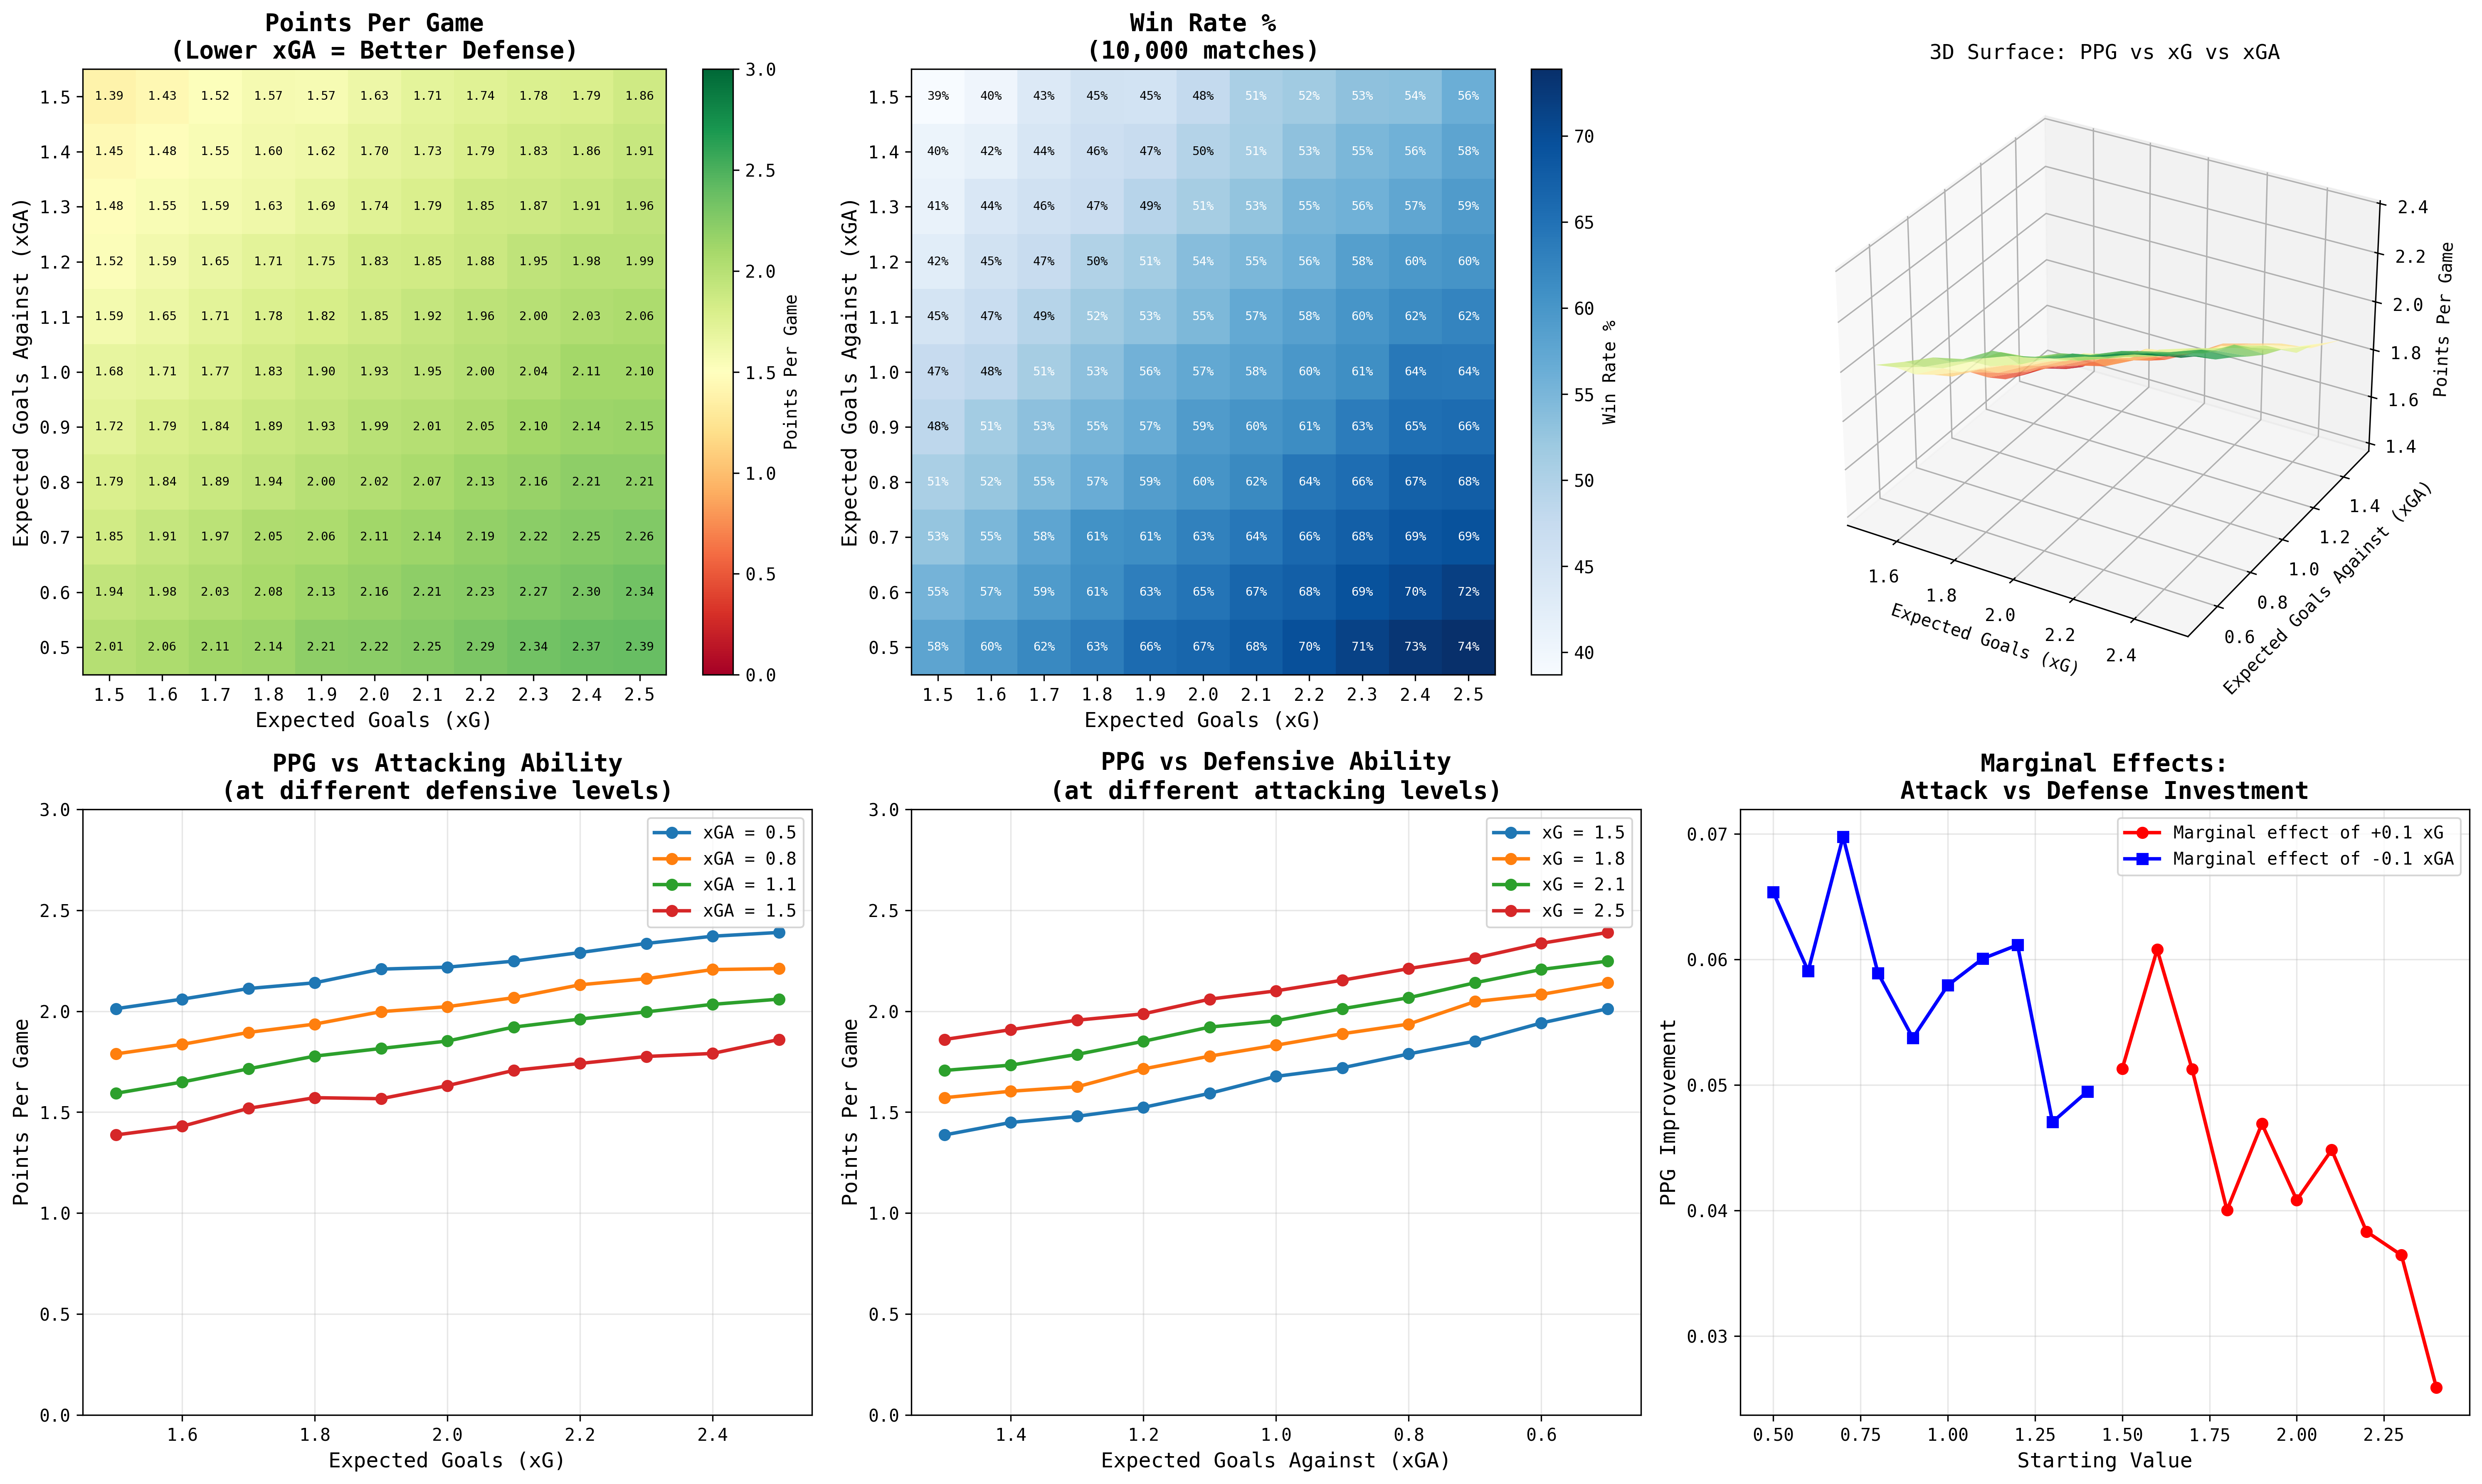

=== GRID SEARCH RESULTS ===

Best combination: xG2.5_xGA0.5
  Points per game: 2.390
  Win rate: 73.9%
  Draw rate: 17.3%
  Loss rate: 8.8%

Worst combination: xG1.5_xGA1.5
  Points per game: 1.387
  Win rate: 38.7%
  Draw rate: 22.6%
  Loss rate: 38.7%

=== KEY INSIGHTS ===

Defensive specialist (xG 1.5, xGA 0.5): 2.012 PPG
Attacking specialist (xG 2.5, xGA 1.5): 1.860 PPG
Balanced team (xG 2.0, xGA 1.0): 1.926 PPG

Correlations with Points Per Game:
xG correlation: 0.598
xGA correlation: -0.796

Average marginal effects:
Average PPG gain from +0.1 xG: 0.0436
Average PPG gain from -0.1 xGA: 0.0582
Defense vs Attack effectiveness ratio: 1.33:1
→ Defense improvements are more valuable than attack improvements

Top 10 performing combinations:
  xG 2.5, xGA 0.5: 2.390 PPG (73.9% wins)
  xG 2.4, xGA 0.5: 2.371 PPG (73.0% wins)
  xG 2.5, xGA 0.6: 2.336 PPG (71.8% wins)
  xG 2.3, xGA 0.5: 2.336 PPG (71.4% wins)
  xG 2.4, xGA 0.6: 2.300 PPG (70.4% wins)
  xG 2.2, xGA 0.5: 2.290 PPG (69.6% win

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd

# Grid search parameters
xg_range = np.arange(1.5, 2.6, 0.1)  # 1.5 to 2.5 with 0.1 steps
xga_range = np.arange(0.5, 1.6, 0.1)  # 0.5 to 1.5 with 0.1 steps
n_matches = 10000  # Number of individual matches to simulate per combination

# Initialize results storage
grid_results = {}

print(f"Running grid search: {len(xg_range)} xG values × {len(xga_range)} xGA values")
print(f"Total combinations: {len(xg_range) * len(xga_range)}")
print(f"Matches per combination: {n_matches}")
print("This may take a few minutes...\n")

# Run grid search
for i, (xg_target, xga_target) in enumerate(product(xg_range, xga_range)):
    team_key = f"xG{xg_target:.1f}_xGA{xga_target:.1f}"
    match_points = []
    
    # Simulate individual matches
    for match in range(n_matches):
        # Generate single match xG and xGA from gamma distributions
        shape = 3.5
        
        # Generate xG for this match
        xg_scale = xg_target / shape
        match_xg = np.random.gamma(shape, xg_scale)
        
        # Generate xGA for this match
        xga_scale = xga_target / shape
        match_xga = np.random.gamma(shape, xga_scale)
        
        # Convert xG/xGA to actual goals using Poisson distribution
        goals_for = np.random.poisson(match_xg)
        goals_against = np.random.poisson(match_xga)
        
        # Calculate points for this match
        if goals_for > goals_against:  # Win
            points = 3
        elif goals_for == goals_against:  # Draw
            points = 1
        else:  # Loss
            points = 0
            
        match_points.append(points)
    
    # Store results
    grid_results[team_key] = {
        'xg_target': xg_target,
        'xga_target': xga_target,
        'points_per_game': np.mean(match_points),
        'std_points': np.std(match_points),
        'win_rate': np.mean([p == 3 for p in match_points]),
        'draw_rate': np.mean([p == 1 for p in match_points]),
        'loss_rate': np.mean([p == 0 for p in match_points]),
        'match_points': match_points
    }
    
    # Progress indicator
    if (i + 1) % 20 == 0 or i == 0:
        print(f"Completed {i + 1}/{len(xg_range) * len(xga_range)} combinations")

print("\nGrid search complete! Generating visualizations...\n")

# Create heatmap data
ppg_data = np.zeros((len(xga_range), len(xg_range)))
win_rate_data = np.zeros((len(xga_range), len(xg_range)))

for i, xga in enumerate(xga_range):
    for j, xg in enumerate(xg_range):
        team_key = f"xG{xg:.1f}_xGA{xga:.1f}"
        ppg_data[i, j] = grid_results[team_key]['points_per_game']
        win_rate_data[i, j] = grid_results[team_key]['win_rate'] * 100

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Points per game heatmap
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(ppg_data, cmap='RdYlGn', aspect='auto', origin='lower', vmin=0, vmax=3)
ax1.set_xticks(range(len(xg_range)))
ax1.set_yticks(range(len(xga_range)))
ax1.set_xticklabels([f'{x:.1f}' for x in xg_range])
ax1.set_yticklabels([f'{y:.1f}' for y in xga_range])
ax1.set_xlabel('Expected Goals (xG)', fontsize=12)
ax1.set_ylabel('Expected Goals Against (xGA)', fontsize=12)
ax1.set_title('Points Per Game\n(Lower xGA = Better Defense)', fontsize=14, fontweight='bold')

# Add text annotations for PPG values
for i in range(len(xga_range)):
    for j in range(len(xg_range)):
        text = ax1.text(j, i, f'{ppg_data[i, j]:.2f}', 
                       ha="center", va="center", color="black", fontsize=7)

plt.colorbar(im1, ax=ax1, label='Points Per Game')

# 2. Win rate heatmap
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(win_rate_data, cmap='Blues', aspect='auto', origin='lower')
ax2.set_xticks(range(len(xg_range)))
ax2.set_yticks(range(len(xga_range)))
ax2.set_xticklabels([f'{x:.1f}' for x in xg_range])
ax2.set_yticklabels([f'{y:.1f}' for y in xga_range])
ax2.set_xlabel('Expected Goals (xG)', fontsize=12)
ax2.set_ylabel('Expected Goals Against (xGA)', fontsize=12)
ax2.set_title('Win Rate %\n(10,000 matches)', fontsize=14, fontweight='bold')

# Add text annotations for win rates
for i in range(len(xga_range)):
    for j in range(len(xg_range)):
        text = ax2.text(j, i, f'{win_rate_data[i, j]:.0f}%', 
                       ha="center", va="center", color="white" if win_rate_data[i, j] > 50 else "black", fontsize=7)

plt.colorbar(im2, ax=ax2, label='Win Rate %')

# 3. 3D surface plot for PPG
ax3 = plt.subplot(2, 3, 3, projection='3d')
X, Y = np.meshgrid(xg_range, xga_range)
ax3.plot_surface(X, Y, ppg_data, cmap='RdYlGn', alpha=0.8)
ax3.set_xlabel('Expected Goals (xG)')
ax3.set_ylabel('Expected Goals Against (xGA)')
ax3.set_zlabel('Points Per Game')
ax3.set_title('3D Surface: PPG vs xG vs xGA')

# 4. Cross-sections: PPG vs xG at different xGA levels
ax4 = plt.subplot(2, 3, 4)
for xga_val in [0.5, 0.8, 1.1, 1.5]:
    xga_idx = np.argmin(np.abs(xga_range - xga_val))
    ppg_at_xga = ppg_data[xga_idx, :]
    ax4.plot(xg_range, ppg_at_xga, marker='o', linewidth=2, label=f'xGA = {xga_val:.1f}')

ax4.set_xlabel('Expected Goals (xG)', fontsize=12)
ax4.set_ylabel('Points Per Game', fontsize=12)
ax4.set_title('PPG vs Attacking Ability\n(at different defensive levels)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 3)

# 5. Cross-sections: PPG vs xGA at different xG levels
ax5 = plt.subplot(2, 3, 5)
for xg_val in [1.5, 1.8, 2.1, 2.5]:
    xg_idx = np.argmin(np.abs(xg_range - xg_val))
    ppg_at_xg = ppg_data[:, xg_idx]
    ax5.plot(xga_range, ppg_at_xg, marker='o', linewidth=2, label=f'xG = {xg_val:.1f}')

ax5.set_xlabel('Expected Goals Against (xGA)', fontsize=12)
ax5.set_ylabel('Points Per Game', fontsize=12)
ax5.set_title('PPG vs Defensive Ability\n(at different attacking levels)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.invert_xaxis()  # Invert so better defense (lower xGA) is on the right
ax5.set_ylim(0, 3)

# 6. Marginal effects plot
ax6 = plt.subplot(2, 3, 6)

# Calculate marginal effects
xg_marginal_effects = []
xga_marginal_effects = []

for i in range(len(xg_range)-1):
    # Average effect of increasing xG by 0.1 across all xGA levels
    effect = np.mean(ppg_data[:, i+1] - ppg_data[:, i])
    xg_marginal_effects.append(effect)

for i in range(len(xga_range)-1):
    # Average effect of reducing xGA by 0.1 across all xG levels
    effect = np.mean(ppg_data[i, :] - ppg_data[i+1, :])  # Note: reduction in xGA is improvement
    xga_marginal_effects.append(effect)

ax6.plot(xg_range[:-1], xg_marginal_effects, 'o-', linewidth=2, label='Marginal effect of +0.1 xG', color='red')
ax6.plot(xga_range[:-1], xga_marginal_effects, 's-', linewidth=2, label='Marginal effect of -0.1 xGA', color='blue')
ax6.set_xlabel('Starting Value', fontsize=12)
ax6.set_ylabel('PPG Improvement', fontsize=12)
ax6.set_title('Marginal Effects:\nAttack vs Defense Investment', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best and worst combinations
best_combo = max(grid_results.keys(), key=lambda x: grid_results[x]['points_per_game'])
worst_combo = min(grid_results.keys(), key=lambda x: grid_results[x]['points_per_game'])

print("=== GRID SEARCH RESULTS ===\n")
print(f"Best combination: {best_combo}")
print(f"  Points per game: {grid_results[best_combo]['points_per_game']:.3f}")
print(f"  Win rate: {grid_results[best_combo]['win_rate']*100:.1f}%")
print(f"  Draw rate: {grid_results[best_combo]['draw_rate']*100:.1f}%")
print(f"  Loss rate: {grid_results[best_combo]['loss_rate']*100:.1f}%")

print(f"\nWorst combination: {worst_combo}")
print(f"  Points per game: {grid_results[worst_combo]['points_per_game']:.3f}")
print(f"  Win rate: {grid_results[worst_combo]['win_rate']*100:.1f}%")
print(f"  Draw rate: {grid_results[worst_combo]['draw_rate']*100:.1f}%")
print(f"  Loss rate: {grid_results[worst_combo]['loss_rate']*100:.1f}%")

# Analysis of offense vs defense trade-offs
print("\n=== KEY INSIGHTS ===")

# Compare extreme corners
defensive_team = f"xG{xg_range[0]:.1f}_xGA{xga_range[0]:.1f}"  # Low xG, Low xGA
attacking_team = f"xG{xg_range[-1]:.1f}_xGA{xga_range[-1]:.1f}"  # High xG, High xGA
balanced_team = f"xG{xg_range[len(xg_range)//2]:.1f}_xGA{xga_range[len(xga_range)//2]:.1f}"

print(f"\nDefensive specialist (xG {xg_range[0]:.1f}, xGA {xga_range[0]:.1f}): {grid_results[defensive_team]['points_per_game']:.3f} PPG")
print(f"Attacking specialist (xG {xg_range[-1]:.1f}, xGA {xga_range[-1]:.1f}): {grid_results[attacking_team]['points_per_game']:.3f} PPG")
print(f"Balanced team (xG {xg_range[len(xg_range)//2]:.1f}, xGA {xga_range[len(xga_range)//2]:.1f}): {grid_results[balanced_team]['points_per_game']:.3f} PPG")

# Create summary DataFrame for easier analysis
summary_data = []
for key, values in grid_results.items():
    summary_data.append({
        'xG': values['xg_target'],
        'xGA': values['xga_target'],
        'ppg': values['points_per_game'],
        'win_rate': values['win_rate'],
        'draw_rate': values['draw_rate'],
        'loss_rate': values['loss_rate']
    })

df = pd.DataFrame(summary_data)

# Correlation analysis
correlation = df[['xG', 'xGA', 'ppg']].corr()
print(f"\nCorrelations with Points Per Game:")
print(f"xG correlation: {correlation.loc['xG', 'ppg']:.3f}")
print(f"xGA correlation: {correlation.loc['xGA', 'ppg']:.3f}")

# Calculate which is more important: offense or defense
print(f"\nAverage marginal effects:")
print(f"Average PPG gain from +0.1 xG: {np.mean(xg_marginal_effects):.4f}")
print(f"Average PPG gain from -0.1 xGA: {np.mean(xga_marginal_effects):.4f}")

ratio = np.mean(xga_marginal_effects) / np.mean(xg_marginal_effects)
print(f"Defense vs Attack effectiveness ratio: {ratio:.2f}:1")

if ratio > 1:
    print("→ Defense improvements are more valuable than attack improvements")
else:
    print("→ Attack improvements are more valuable than defense improvements")

# Find optimal combinations
print(f"\nTop 10 performing combinations:")
top_10 = df.nlargest(10, 'ppg')[['xG', 'xGA', 'ppg', 'win_rate']]
for idx, row in top_10.iterrows():
    print(f"  xG {row['xG']:.1f}, xGA {row['xGA']:.1f}: {row['ppg']:.3f} PPG ({row['win_rate']*100:.1f}% wins)")

# Efficiency analysis
df['xg_xga_sum'] = df['xG'] + (3.0 - df['xGA'])  # Total "investment" (treating low xGA as high investment)
df['efficiency'] = df['ppg'] / df['xg_xga_sum']

print(f"\nMost efficient combinations (PPG per unit investment):")
top_efficiency = df.nlargest(5, 'efficiency')[['xG', 'xGA', 'ppg', 'efficiency']]
for idx, row in top_efficiency.iterrows():
    print(f"  xG {row['xG']:.1f}, xGA {row['xGA']:.1f}: {row['ppg']:.3f} PPG (efficiency: {row['efficiency']:.4f})")
    